In [1]:
import pandas as pd 
import sklearn
import seaborn as sea
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import xgboost as xgb

## Load in the data

In [2]:
house_prices_train = pd.read_csv('train.csv')
house_prices_test = pd.read_csv('test.csv')
house_prices_train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [5]:
house_prices_all = pd.concat((house_prices_train.loc[:,'MSSubClass':'SaleCondition'], 
                              house_prices_test.loc[:,'MSSubClass':'SaleCondition']))
house_prices_all.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal


In [3]:
house_prices_train.shape, house_prices_test.shape

((1460, 81), (1459, 80))

## Data Processing

In [7]:
print stats.skew(house_prices_train['SalePrice'])
print stats.skew(house_prices_train['SalePrice'].apply(lambda x: np.log1p(x)))

1.88094074603
0.121221913115


In [7]:
house_prices_train['log_SalePrice'] = house_prices_train['SalePrice'].apply(lambda x: np.log1p(x))
house_prices_train.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247699


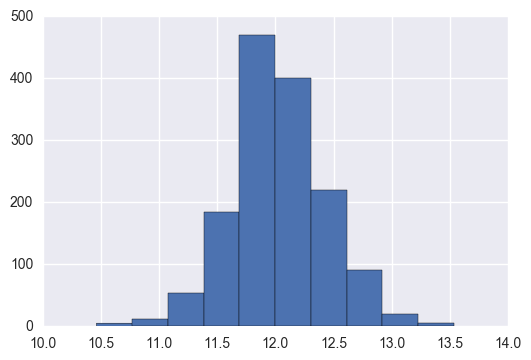

In [8]:
%matplotlib inline  
house_prices_train['log_SalePrice'].hist() #Looks pretty normal!

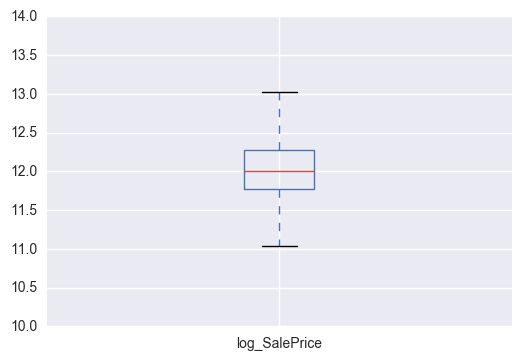

In [9]:
plot = house_prices_train.boxplot(column='log_SalePrice')

In [10]:
house_prices_all = house_prices_all.fillna(house_prices_all.mean()) #replace NaN with mean of the columns

### Log transform skewed features

In [11]:
numerical_features = house_prices_all.columns[house_prices_all.dtypes != 'object']
stats.skew(house_prices_all[numerical_features])

array([  1.37545736,   1.64557379,  12.8224314 ,   0.19711045,
         0.57031205,  -0.59980555,  -0.45102038,   2.61154938,
         1.42523344,   4.14603364,   0.91950831,   1.16248375,
         1.46960442,   0.86167475,  12.088761  ,   1.26935769,
         0.62395504,   3.93134301,   0.16760573,   0.69456649,
         0.32632435,   4.30225437,   0.75836691,   0.7334946 ,
        -0.39279   ,  -0.21829789,   0.24121778,   1.84243281,
         2.53511373,   4.00389122,  11.37606468,   3.9466937 ,
        16.89832792,  21.94719481,   0.19588394,   0.13239881])

In [12]:
skewed_features = house_prices_all[numerical_features].columns[np.absolute(stats.skew(house_prices_all[numerical_features]))>0.8]
print skewed_features
house_prices_all[skewed_features] = house_prices_all[skewed_features].apply(lambda x: np.log1p(x))
house_prices_all.head(2)

Index([u'MSSubClass', u'LotFrontage', u'LotArea', u'MasVnrArea', u'BsmtFinSF1',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF',
       u'LowQualFinSF', u'GrLivArea', u'BsmtHalfBath', u'KitchenAbvGr',
       u'WoodDeckSF', u'OpenPorchSF', u'EnclosedPorch', u'3SsnPorch',
       u'ScreenPorch', u'PoolArea', u'MiscVal'],
      dtype='object')


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal


### One hot encoding

In [13]:
pd.set_option('display.max_columns', 300)
house_prices_all = pd.get_dummies(house_prices_all)
house_prices_all.head(1)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,Garage

In [14]:
house_prices_all.shape

(2919, 288)

#### Split the dataframe into its original train and test with all the data transformation intact

In [48]:
train = house_prices_all[0:len(house_prices_train)]
test = house_prices_all[len(house_prices_train):]
train.shape, test.shape, house_prices_all.shape

((1460, 288), (1459, 288), (2919, 288))

## Gradient Boosting

In [60]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

### Function to fit model and do Cross Validation for error calculation

In [108]:
def modelfit(model, dtrain, features, output, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    model.fit(dtrain[features], output)
        
    #Predict training set:
    dtrain_predictions = model.predict(dtrain[features])
    #dtrain_predprob = model.predict_proba(dtrain[features])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(model, dtrain[features], output, cv=cv_folds)
    
    #Print model report:
    print "\nModel Report"
    print "R-Square: %.3f" % metrics.r2_score(output, dtrain_predictions)
    print "RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(output, dtrain_predictions))
    print"cv_score: "
    print(cv_score)

    if performCV:
        print "CV Score : Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_[0:30], features[0:30]).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Top 30 Feature Importances')
        plt.ylabel('Features Importance Score')

### Baseline Model

(1460, 288) (1460,)

Model Report
R-Square: 0.959
RMSE : 0.081
cv_score: 
[ 0.90787581  0.89357339  0.89735139  0.90985761  0.89418972]
CV Score : Mean: 0.9005696 | Std: 0.006923216 | Min: 0.8935734 | Max: 0.9098576


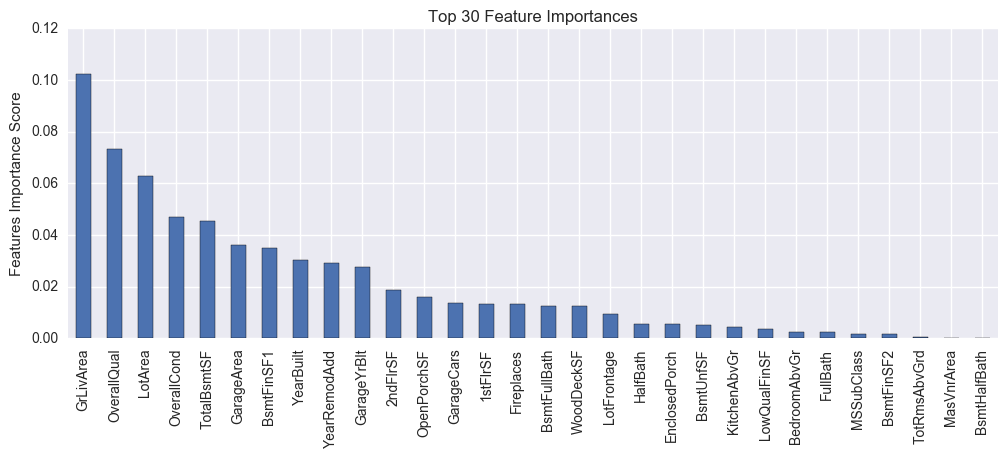

In [109]:
#features = [x for x in train.columns if x not in ['SalePrice', 'log_SalePrice']]
features = train.columns
train_output = house_prices_train['log_SalePrice']
print train[features].shape, output.shape
#print output
gbm = GradientBoostingRegressor(random_state=10)
modelfit(gbm, train, features, output, performCV=True, printFeatureImportance=True)

Mean CV score is 0.9006 and we should be able to do better so lets keep going!

### Parameter Tuning

In [154]:
min_samples_split = 0.01  #This should be ~0.5-1% of total values. 
min_samples_leaf = 50 #Can be selected based on intuition. This is just used for preventing overfitting 
max_depth = 3
max_features = 'sqrt' #Its a general thumb-rule to start with square root.
subsample = 0.8 #This is a commonly used used start value

In [168]:
param_test1 = {'n_estimators': range(20,501,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.3, min_samples_split=min_samples_split, 
                                                              min_samples_leaf=min_samples_leaf,max_depth=max_depth,
                                                              max_features=max_features,
                                                              subsample=subsample,random_state=10), 
                                                              param_grid = param_test1, n_jobs=4,iid=False,cv=5)

In [169]:
gsearch1.fit(train[features], output)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.3, loss='ls',
             max_depth=3, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=50, min_samples_split=0.01,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [171]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.84768, std: 0.01022, params: {'n_estimators': 20},
  mean: 0.85865, std: 0.01308, params: {'n_estimators': 30},
  mean: 0.86530, std: 0.01332, params: {'n_estimators': 40},
  mean: 0.86906, std: 0.01477, params: {'n_estimators': 50},
  mean: 0.87154, std: 0.01433, params: {'n_estimators': 60},
  mean: 0.87285, std: 0.01474, params: {'n_estimators': 70},
  mean: 0.87330, std: 0.01533, params: {'n_estimators': 80},
  mean: 0.87413, std: 0.01531, params: {'n_estimators': 90},
  mean: 0.87374, std: 0.01488, params: {'n_estimators': 100},
  mean: 0.87465, std: 0.01526, params: {'n_estimators': 110},
  mean: 0.87507, std: 0.01551, params: {'n_estimators': 120},
  mean: 0.87597, std: 0.01513, params: {'n_estimators': 130},
  mean: 0.87621, std: 0.01596, params: {'n_estimators': 140},
  mean: 0.87622, std: 0.01597, params: {'n_estimators': 150},
  mean: 0.87602, std: 0.01641, params: {'n_estimators': 160},
  mean: 0.87595, std: 0.01583, params: {'n_estimators': 170},
  mean: 0.87537,

### Tuning tree-specific parameters

Now lets move onto tuning the tree parameters. I plan to do this in following stages:

Tune max_depth and num_samples_split
Tune min_samples_leaf
Tune max_features

In [181]:
param_test2 = {'max_depth': range(1,16,2), 'min_samples_split': np.arange(0.001, 0.011, 0.001)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.3, n_estimators=150, max_features=max_features, 
                                                              min_samples_leaf=min_samples_leaf, 
                                                              subsample=subsample, random_state=10), 
                                                    param_grid = param_test2 ,n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[features],output)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.86794, std: 0.01422, params: {'min_samples_split': 0.001, 'max_depth': 1},
  mean: 0.86794, std: 0.01422, params: {'min_samples_split': 0.002, 'max_depth': 1},
  mean: 0.86794, std: 0.01422, params: {'min_samples_split': 0.0030000000000000001, 'max_depth': 1},
  mean: 0.86794, std: 0.01422, params: {'min_samples_split': 0.0040000000000000001, 'max_depth': 1},
  mean: 0.86794, std: 0.01422, params: {'min_samples_split': 0.0050000000000000001, 'max_depth': 1},
  mean: 0.86794, std: 0.01422, params: {'min_samples_split': 0.0060000000000000001, 'max_depth': 1},
  mean: 0.86794, std: 0.01422, params: {'min_samples_split': 0.0070000000000000001, 'max_depth': 1},
  mean: 0.86794, std: 0.01422, params: {'min_samples_split': 0.0080000000000000002, 'max_depth': 1},
  mean: 0.86794, std: 0.01422, params: {'min_samples_split': 0.0090000000000000011, 'max_depth': 1},
  mean: 0.86794, std: 0.01422, params: {'min_samples_split': 0.010000000000000002, 'max_depth': 1},
  mean: 0.87622, std: 0

In [182]:
min_samples_split = 0.001  
min_samples_leaf = 50 
max_depth = 3
max_features = 'sqrt'
subsample = 0.8
n_estimators=150
learning_rate=0.3

In [185]:
param_test3 = {'min_samples_leaf':range(10,101,10), 'max_features':range(7,30,2)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                                              min_samples_split=min_samples_split,max_depth=max_depth, 
                                                              subsample=0.8, random_state=10), 
                                                param_grid = param_test3, n_jobs=4, iid=False, cv=5)
gsearch3.fit(train[features], output)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.87233, std: 0.01029, params: {'max_features': 7, 'min_samples_leaf': 10},
  mean: 0.87719, std: 0.00940, params: {'max_features': 7, 'min_samples_leaf': 20},
  mean: 0.87281, std: 0.01447, params: {'max_features': 7, 'min_samples_leaf': 30},
  mean: 0.86897, std: 0.01546, params: {'max_features': 7, 'min_samples_leaf': 40},
  mean: 0.86822, std: 0.01380, params: {'max_features': 7, 'min_samples_leaf': 50},
  mean: 0.86430, std: 0.01235, params: {'max_features': 7, 'min_samples_leaf': 60},
  mean: 0.85739, std: 0.01446, params: {'max_features': 7, 'min_samples_leaf': 70},
  mean: 0.85172, std: 0.01551, params: {'max_features': 7, 'min_samples_leaf': 80},
  mean: 0.84525, std: 0.01359, params: {'max_features': 7, 'min_samples_leaf': 90},
  mean: 0.84619, std: 0.01461, params: {'max_features': 7, 'min_samples_leaf': 100},
  mean: 0.86741, std: 0.01287, params: {'max_features': 9, 'min_samples_leaf': 10},
  mean: 0.86697, std: 0.01699, params: {'max_features': 9, 'min_samples_lea

#### Optimum parameters so far: 

In [189]:
min_samples_split = 0.001  
min_samples_leaf = 20 
max_depth = 3
max_features = 29
subsample = 0.8
n_estimators=150
learning_rate=0.3


Model Report
R-Square: 0.957
RMSE : 0.083
cv_score: 
[ 0.89576248  0.88097111  0.88417541  0.8857439   0.87343531]
CV Score : Mean: 0.8840176 | Std: 0.007241728 | Min: 0.8734353 | Max: 0.8957625


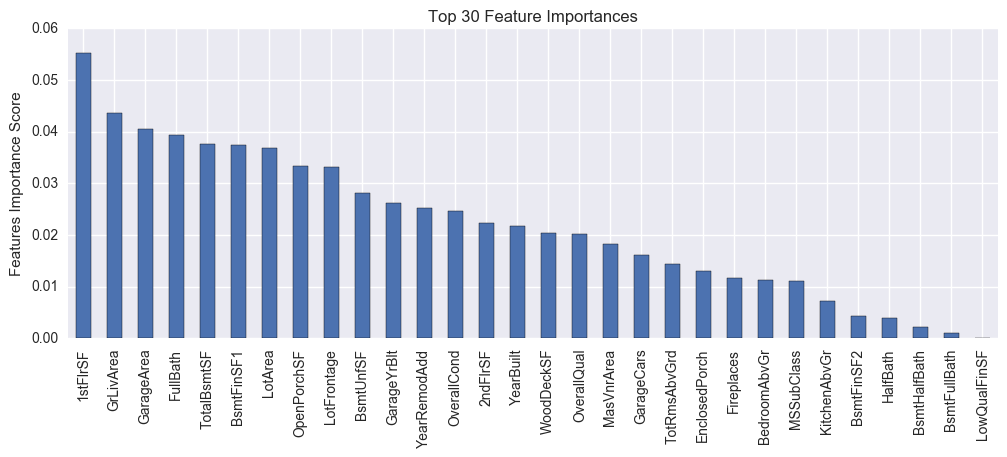

In [190]:
modelfit(gsearch3.best_estimator_, train, features, output)

If you compare the feature importance of this model with the baseline model, you’ll find that now we are able to derive value from many more variables. CV Score has gone down and RMSE has gone up, no performance is not as good as baseline model! This could be due to higher learning rate used so lets tune that down!

#### Lets tune subsample

In [192]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9, 0.95, 1.0]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                                               max_depth=max_depth,min_samples_split=min_samples_split, 
                                                               min_samples_leaf=min_samples_leaf, random_state=10,
                                                               max_features=max_features),
                                                param_grid = param_test5,n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[features],output)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.87819, std: 0.01695, params: {'subsample': 0.6},
  mean: 0.87669, std: 0.01770, params: {'subsample': 0.7},
  mean: 0.87644, std: 0.01342, params: {'subsample': 0.75},
  mean: 0.88402, std: 0.00724, params: {'subsample': 0.8},
  mean: 0.88291, std: 0.00897, params: {'subsample': 0.85},
  mean: 0.88754, std: 0.01354, params: {'subsample': 0.9},
  mean: 0.88503, std: 0.00981, params: {'subsample': 0.95},
  mean: 0.88397, std: 0.00737, params: {'subsample': 1.0}],
 {'subsample': 0.9},
 0.88753719626393823)

#### Lets decrease learning rate by half and double the number of trees

In [198]:
min_samples_split = 0.001  
min_samples_leaf = 20 
max_depth = 3
max_features = 29
subsample = 0.9
n_estimators=300
learning_rate=0.15


Model Report
R-Square: 0.964
RMSE : 0.075
cv_score: 
[ 0.91441176  0.90479091  0.88726714  0.90642328  0.89117827]
CV Score : Mean: 0.9008143 | Std: 0.01008507 | Min: 0.8872671 | Max: 0.9144118


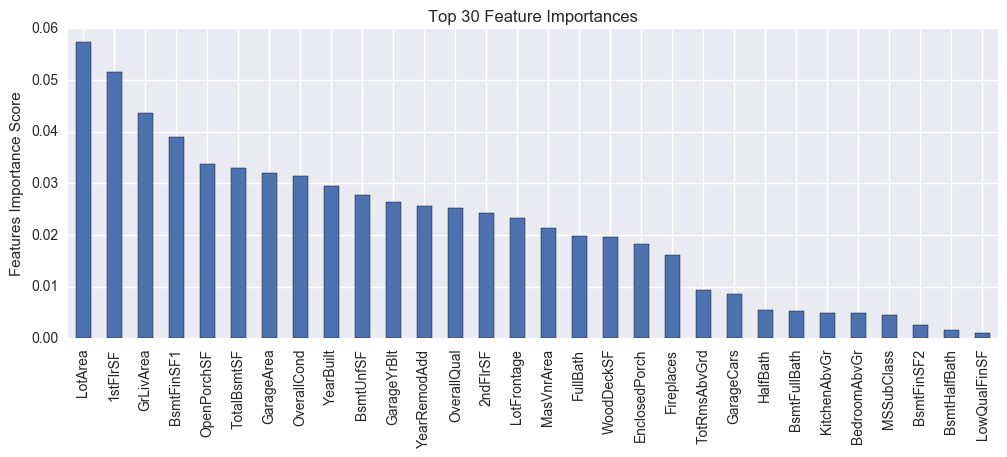

In [199]:
gbm_tuned_1 = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)
modelfit(gbm_tuned_1, train, features, output)

#### Lets further decrease learning rate by half and increase the number of trees

In [200]:
min_samples_split = 0.001  
min_samples_leaf = 20 
max_depth = 3
max_features = 29
subsample = 0.9
n_estimators=600
learning_rate=0.075


Model Report
R-Square: 0.968
RMSE : 0.072
cv_score: 
[ 0.91559875  0.90274567  0.89530648  0.91272359  0.8950806 ]
CV Score : Mean: 0.904291 | Std: 0.008566388 | Min: 0.8950806 | Max: 0.9155988


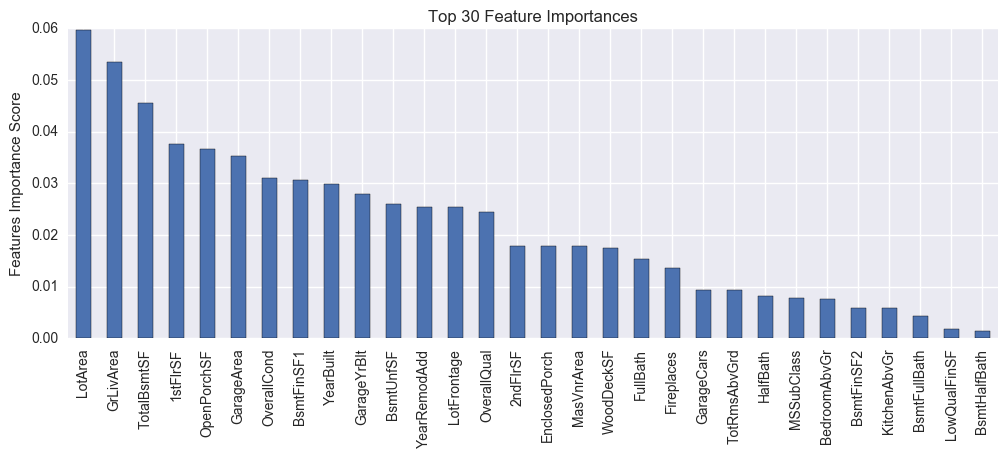

In [201]:
gbm_tuned_2 = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)
modelfit(gbm_tuned_2, train, features, output)

#### Now lets reduce learning rate to one-tenth of the original value, i.e. 0.03 

In [202]:
min_samples_split = 0.001  
min_samples_leaf = 20 
max_depth = 3
max_features = 29
subsample = 0.9
n_estimators=1500
learning_rate=0.03


Model Report
R-Square: 0.969
RMSE : 0.071
cv_score: 
[ 0.91660881  0.9078334   0.90023572  0.91462321  0.89849028]
CV Score : Mean: 0.9075583 | Std: 0.007317782 | Min: 0.8984903 | Max: 0.9166088


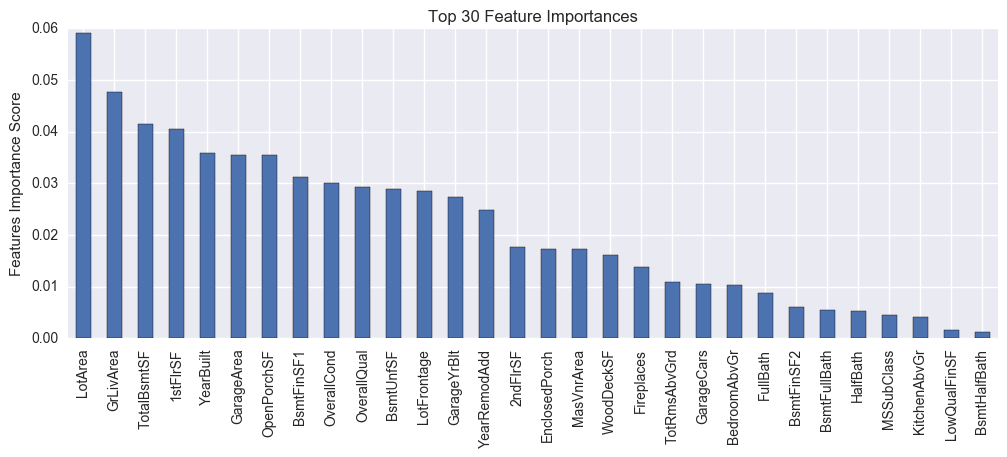

In [203]:
gbm_tuned_3 = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)
modelfit(gbm_tuned_3, train, features, output)

#### Now lets reduce learning rate to one-twentieth of the original value, i.e. 0.015

In [204]:
min_samples_split = 0.001  
min_samples_leaf = 20 
max_depth = 3
max_features = 29
subsample = 0.9
n_estimators=3000
learning_rate=0.015


Model Report
R-Square: 0.969
RMSE : 0.070
cv_score: 
[ 0.91870027  0.90641669  0.90229493  0.91449818  0.89883848]
CV Score : Mean: 0.9081497 | Std: 0.007424263 | Min: 0.8988385 | Max: 0.9187003


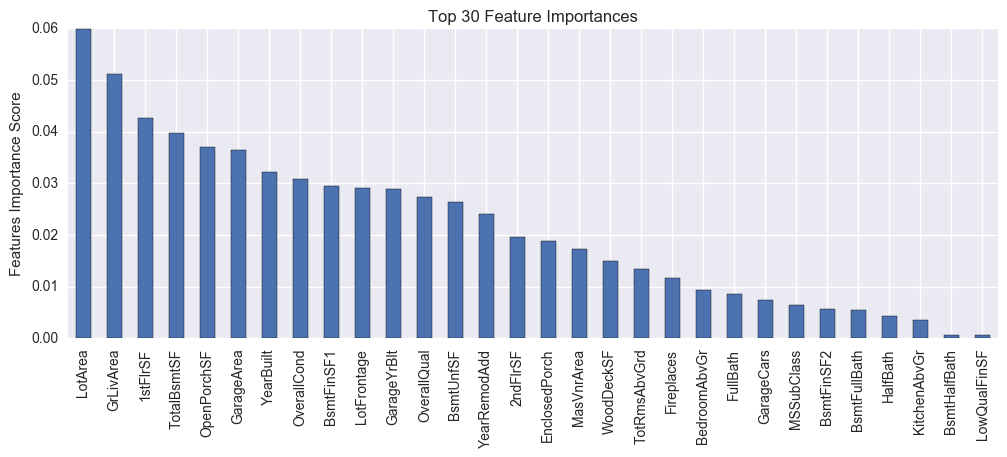

In [205]:
gbm_tuned_4 = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)
modelfit(gbm_tuned_4, train, features, output)

### Time to make predictions and submit to kaggle

In [211]:
pred = np.expm1(gbm_tuned_1.predict(test))
gbm_tuned_1_prediction = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
gbm_tuned_1_prediction.head(5)

,Id,SalePrice
0,1461,120515.873909
1,1462,163069.249429
2,1463,182314.286866
3,1464,184875.422120
4,1465,178566.890565


In [213]:
gbm_tuned_1_prediction.to_csv('kaggle_submission_gbm1_12202016.csv', index=False)

In [214]:
pred = np.expm1(gbm_tuned_2.predict(test))
gbm_tuned_2_prediction = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
gbm_tuned_2_prediction.head(5)

,Id,SalePrice
0,1461,127611.869509
1,1462,164773.757758
2,1463,176677.123525
3,1464,183863.986092
4,1465,187586.653009


In [215]:
gbm_tuned_2_prediction.to_csv('kaggle_submission_gbm2_12202016.csv', index=False)

In [216]:
pred = np.expm1(gbm_tuned_3.predict(test))
gbm_tuned_3_prediction = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
gbm_tuned_3_prediction.head(5)

,Id,SalePrice
0,1461,120093.323411
1,1462,164032.675231
2,1463,181405.247879
3,1464,192018.941609
4,1465,189233.612793


In [217]:
gbm_tuned_3_prediction.to_csv('kaggle_submission_gbm3_12202016.csv', index=False)

In [218]:
pred = np.expm1(gbm_tuned_4.predict(test))
gbm_tuned_4_prediction = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
gbm_tuned_4_prediction.head(5)

,Id,SalePrice
0,1461,122399.218462
1,1462,161498.857155
2,1463,183873.471887
3,1464,191490.045717
4,1465,192704.855396


In [219]:
gbm_tuned_4_prediction.to_csv('kaggle_submission_gbm4_12202016.csv', index=False)

### None of the above improved the LB Score over Ridge Regression! :( :( Lets keep trying

In [229]:
min_samples_split = 0.001  
min_samples_leaf = 20 
max_depth = 3
max_features = 29
subsample = 0.9
n_estimators=30000
learning_rate=0.0015


Model Report
R-Square: 0.969
RMSE : 0.070
cv_score: 
[ 0.92328629  0.90581639  0.90280078  0.91617828  0.89724968]
CV Score : Mean: 0.9090663 | Std: 0.009404675 | Min: 0.8972497 | Max: 0.9232863


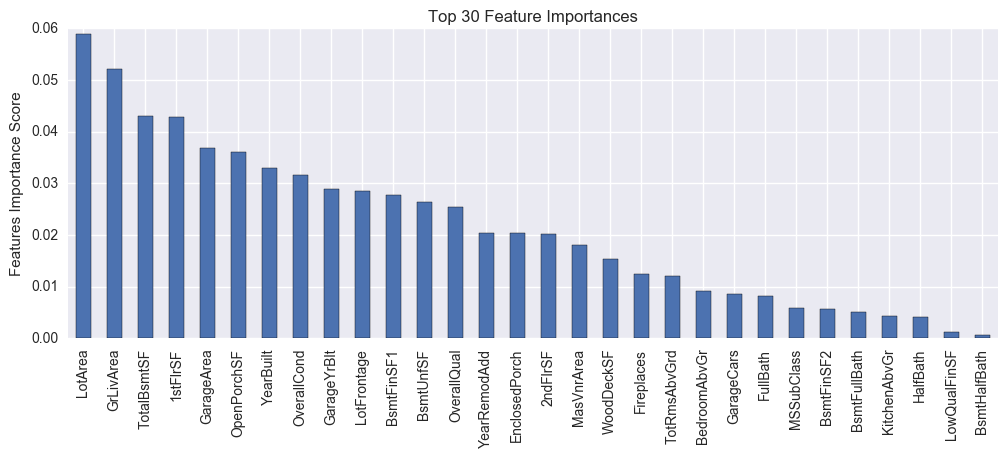

In [230]:
gbm_tuned_5 = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)
modelfit(gbm_tuned_5, train, features, output)

In [231]:
pred = np.expm1(gbm_tuned_5.predict(test))
gbm_tuned_5_prediction = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
gbm_tuned_5_prediction.head(5)

,Id,SalePrice
0,1461,122035.292708
1,1462,160532.645518
2,1463,184200.397737
3,1464,195402.706237
4,1465,192402.247416


In [232]:
gbm_tuned_5_prediction.to_csv('kaggle_submission_gbm5_12202016.csv', index=False)